In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import mne, re, os, pickle, shutil
import torch

from utils import *

In [2]:
def normalize(x, minimum=-0.00125, maximum=0.00125):
    return (x - minimum) / (maximum - minimum) * 2 - 1

def save_concept(DATA_PATH_CONCEPTS, raw, concept, patient, run, idx, NUMBER_CHANNELS=20, NUMBER_SAMPLES=1024):

    x = torch.zeros((1, NUMBER_CHANNELS, NUMBER_SAMPLES))
    x[:, :NUMBER_CHANNELS-1, :] = torch.from_numpy(raw.copy().get_data()[:, :NUMBER_SAMPLES].reshape(1, NUMBER_CHANNELS-1, NUMBER_SAMPLES))
    x = normalize(x)
    x[:,NUMBER_CHANNELS-1,:] = torch.ones((1, NUMBER_SAMPLES)) * -1  
    
    picklePath = DATA_PATH_CONCEPTS + concept + '/' + patient + run + '_' + idx + '_' + concept + '.pkl'
    with open(picklePath, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def make_concepts_folders(DATA_PATH_CONCEPTS, bands_to_use, label_names):

    # remove and remake concepts folder
    print('Removing and remaking concepts folder: ', DATA_PATH_CONCEPTS)

    if os.path.exists(DATA_PATH_CONCEPTS):
        shutil.rmtree(DATA_PATH_CONCEPTS)
    os.mkdir(DATA_PATH_CONCEPTS)

    for label_idx in range(len(label_names)):
        for band in bands_to_use:
        # make directory if it doesn't exist
            if not os.path.exists(f'{DATA_PATH_CONCEPTS}{band}_{label_names[label_idx]}'):
                os.makedirs(f'{DATA_PATH_CONCEPTS}{band}_{label_names[label_idx]}')

def save_concept(window, concept, DATA_PATH_CONCEPTS, edf_file, idx, NUMBER_CHANNELS=20, NUMBER_SAMPLES=1024):

    x = torch.zeros((1, NUMBER_CHANNELS, NUMBER_SAMPLES))

    x[:, :NUMBER_CHANNELS-1, :] = torch.from_numpy(window)
    x[:,NUMBER_CHANNELS-1,:] = torch.ones((1, NUMBER_SAMPLES)) * -1  
    
    picklePath = DATA_PATH_CONCEPTS + concept + '/' + edf_file[:-4] + '_' + str(idx) + '_' + concept + '.pkl'
    with open(picklePath, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [3]:
ACTIVITY_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/Activity/'

In [4]:
def sort_dict(dict):
    return {k: dict[k] for k in sorted(dict.keys())}

PARCELLATION = 'HCPMMP1_combined'

delta_activity = np.load(ACTIVITY_PATH + 'HCPMMP1_combined_1.0_4.0_213638_280423.npy', allow_pickle=True).item()
theta_activity = np.load(ACTIVITY_PATH + 'HCPMMP1_combined_4.0_8.0_220344_280423.npy', allow_pickle=True).item()
alpha_activity = np.load(ACTIVITY_PATH + 'HCPMMP1_combined_8.0_12.0_220503_280423.npy', allow_pickle=True).item()
beta_activity = np.load(ACTIVITY_PATH + 'HCPMMP1_combined_12.0_30.0_222628_280423.npy', allow_pickle=True).item()
gamma_activity = np.load(ACTIVITY_PATH + 'HCPMMP1_combined_30.0_70.0_225658_280423.npy', allow_pickle=True).item()

activity_dict = {
    'Delta': sort_dict(delta_activity),
    'Theta': sort_dict(theta_activity),
    'Alpha': sort_dict(alpha_activity),
    'Beta': sort_dict(beta_activity),
    'Gamma': sort_dict(gamma_activity)
}

bands = list(activity_dict.keys())
#bands = ['Alpha', 'Gamma']
edf_files = list(activity_dict[bands[0]].keys())

In [5]:
DATA_PATH_RAW = '/home/williamtheodor/Documents/DL for EEG Classification/data/tuh_eeg/'
DATA_PATH_CONCEPTS = '/home/williamtheodor/Documents/DL for EEG Classification/data/tuh concepts/'

NUMBER_CHANNELS = 20
NUMBER_SAMPLES = 1024

subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
labels = get_labels(subjects_dir, parcellation_name=PARCELLATION)
label_names = [label.name for label in np.array(labels).flatten()]

make_concepts_folders(DATA_PATH_CONCEPTS, bands, label_names)

Removing and remaking concepts folder:  /home/williamtheodor/Documents/DL for EEG Classification/data/tuh concepts/


In [6]:
channel_order = [
                'Fp1', 'Fp2',
        'F7', 'F3', 'Fz', 'F4', 'F8',
        'T3', 'C3', 'Cz', 'C4', 'T4',
        'T5', 'P3', 'Pz', 'P4', 'T6',
                 'O1', 'O2'
    ]


for edf_file in tqdm(edf_files, total=len(edf_files)): 

    FILE = DATA_PATH_RAW + edf_file
    raw = read_TUH_edf(FILE, low_pass=None)

    try:
        raw.reorder_channels(channel_order)
    except:
        continue

    annotations = activity_dict['Alpha'][edf_file]['annotations']['T0']

    baseline_power = np.array([activity_dict[band][edf_file]['power']['T0'].mean(axis=0) for band in bands])
    baseline_variance = np.array([activity_dict[band][edf_file]['variance']['T0'].mean(axis=0) for band in bands])

    for idx, annotation in enumerate(annotations):
        window = get_window(raw, annotation).get_data()
        window = normalize(window)

        power = np.array([activity_dict[band][edf_file]['power']['T0'][idx] for band in bands])
        power = np.abs(power - baseline_power) / np.sqrt(baseline_variance)

        most_active_band_idx = np.argmax(power.mean(axis=1))
        most_active_band = bands[most_active_band_idx]

        brain_region_idx = power[most_active_band_idx].argmax()
        brain_region = label_names[brain_region_idx]

        concept = most_active_band + '_' + brain_region

        save_concept(window, concept, DATA_PATH_CONCEPTS, edf_file, idx)

100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


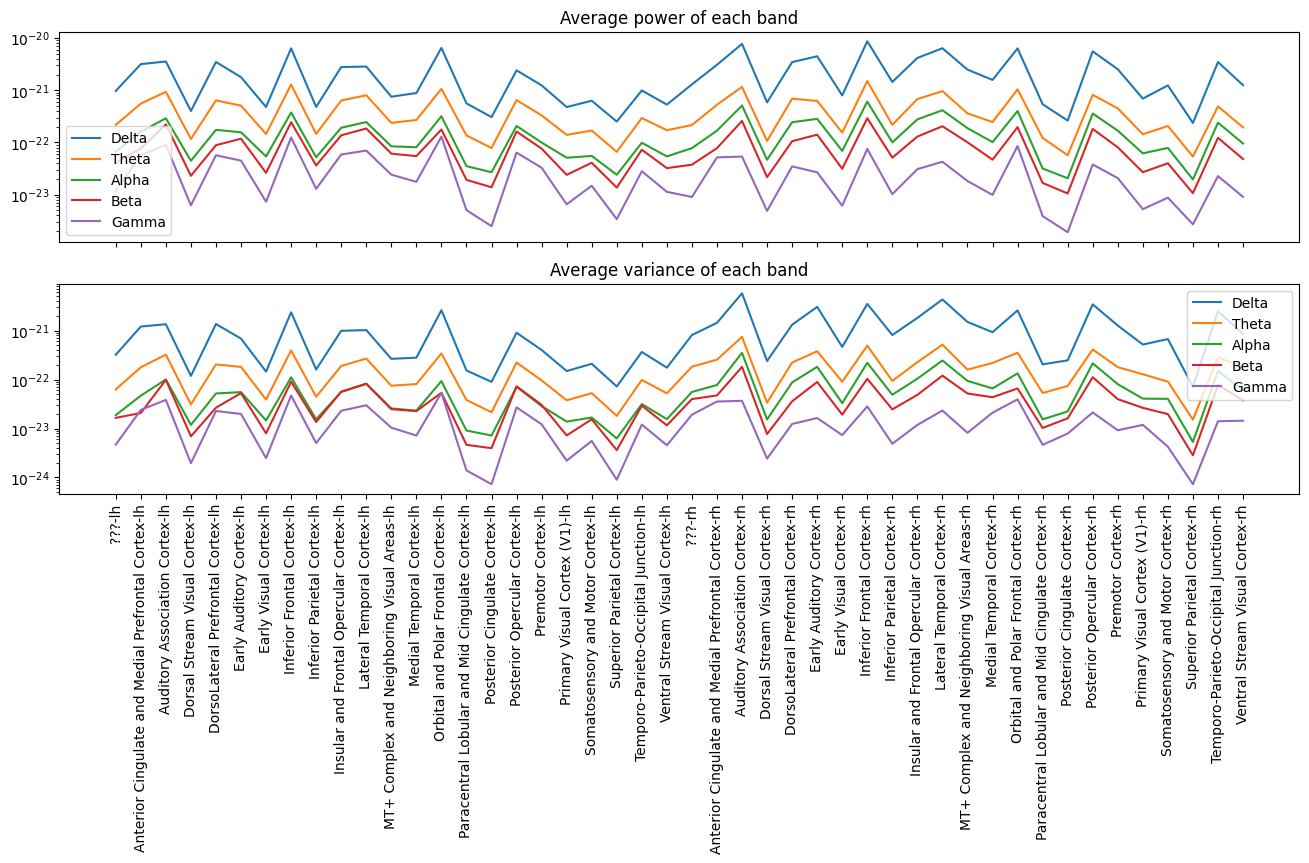

In [13]:
# visualize the average power of each band

fig, ax = plt.subplots(2, 1, figsize=(16, 6), sharex=True)


for band in bands:
    ax[0].plot(activity_dict[band][edf_file]['power']['T0'].mean(axis=0), label=band)
    ax[1].plot(activity_dict[band][edf_file]['variance']['T0'].mean(axis=0), label=band)


ax[0].set_yscale('log')
ax[1].set_yscale('log')

#set xtick to match label_names
ax[1].set_xticks(np.arange(len(label_names)))
ax[1].set_xticklabels(label_names, rotation=90)

ax[0].set_title('Average power of each band')
ax[1].set_title('Average variance of each band')
ax[0].legend()
ax[1].legend()




plt.show()

